# 5 Useful Data Wrangling Techniques Using Python Pandas and data.world    
### This notebook demonstrates a collection of data wrangling problems I frequently encounter, and my approaches to solving them.    
What this tutorial **is not**: 
* a comprehensive tutorial on data wrangling
* the only or even the best solutions    

What this tutorial **is**:
* fun and interesting (hopefully)
* things I encounter often in my work
* the best solutions I'm aware of (at this time)

### Agenda:
1. Standardize a large, messy datetime column
2. Change time zones
3. "Standardizing" text (string) columns 
4. Multiprocessing
5. Reshaping dataframes with melt, pivot, & groupby   

### Import Packages

In [37]:
import pandas as pd               # data wrangling library
import datadotworld as ddw        # data.world SDK
import numpy as np                # data manipulation, math, linear algebra library
import matplotlib.pyplot as plt   # matlab style data visualization library
from fuzzywuzzy import process    # fuzzy string matching
import time                       # to measure processing time
import pytz                       # time zones
import re                         # Python regex
import multiprocessing as mp      # multicore distributed processing
from __future__ import print_function

%matplotlib inline

In [2]:
#! pip install watermark
%load_ext watermark
% watermark -a "Noah Rippner -- data scientist, data.world" -d -v \
                             -p pandas,numpy,datadotworld,fuzzywuzzy

Noah Rippner -- data scientist, data.world 2017-05-18 

CPython 3.6.1
IPython 6.0.0

pandas 0.20.1
numpy 1.12.1
datadotworld 1.2.0
fuzzywuzzy 0.15.0


# 1. Standardize a large, messy datetime column      
Note, hat tip to data.world user @hipplec for suggesting this technique on a [thread in data.world](https://data.world/databrett/white-house-visitors-2015-6/discuss/data-preparation/7533)     
For this example, we'll use some data I've hosted [here](https://data.world/nrippner/my-dataset) on data.world. The data table we're interested is a selection of three columns from the White House Visitor Logs dataset covering the years 2008 through 2016.     
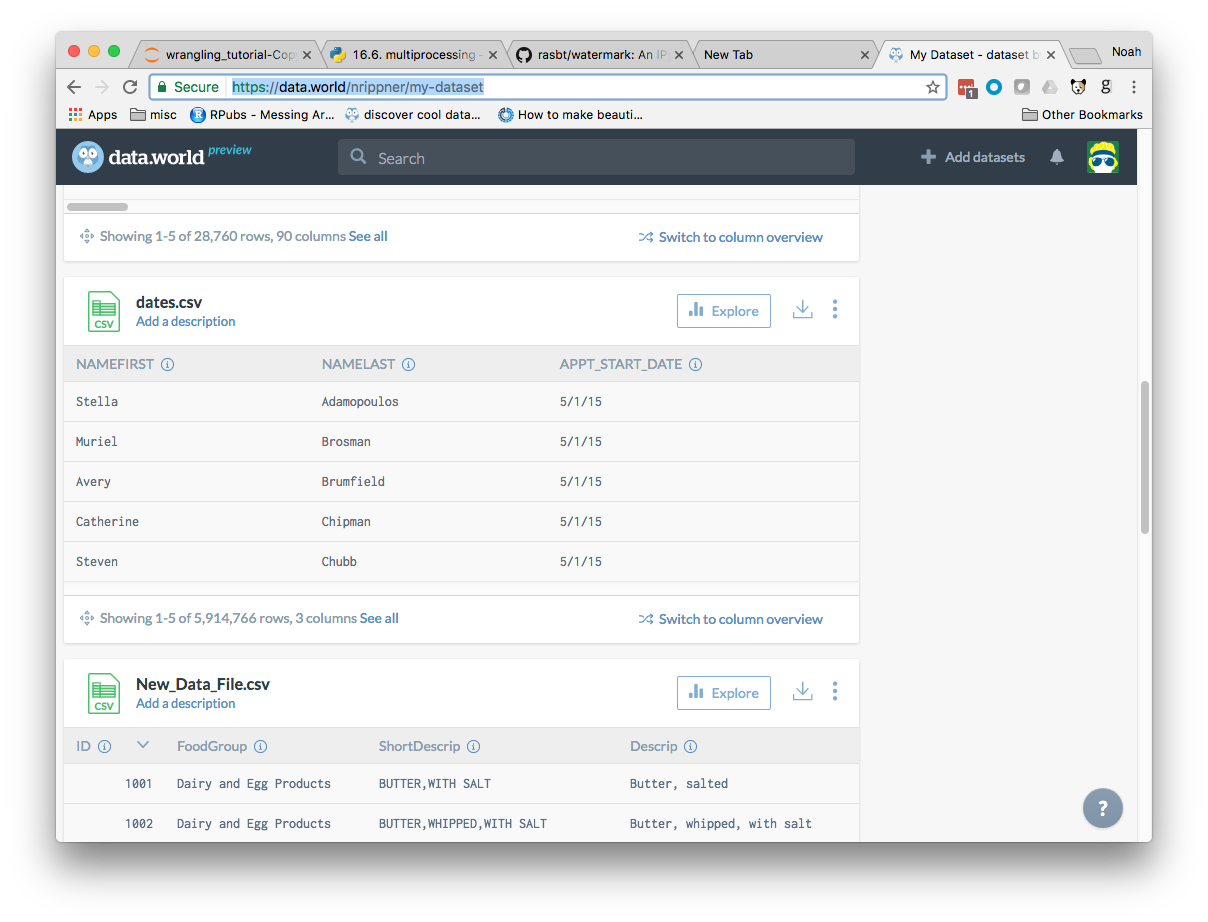

We can see that the data file -- dates.csv -- has 3 columns and nearly 6 million rows.   
First, let's import the data from data.world.   
**(!)**Note: due to the large size (6 million rows), we're going to using the "Copy URL, Python/Pandas, or R code" approach to importing this data into Python (as opposed to writing a query) to avoid the compute time associated with querying over so many cells. 

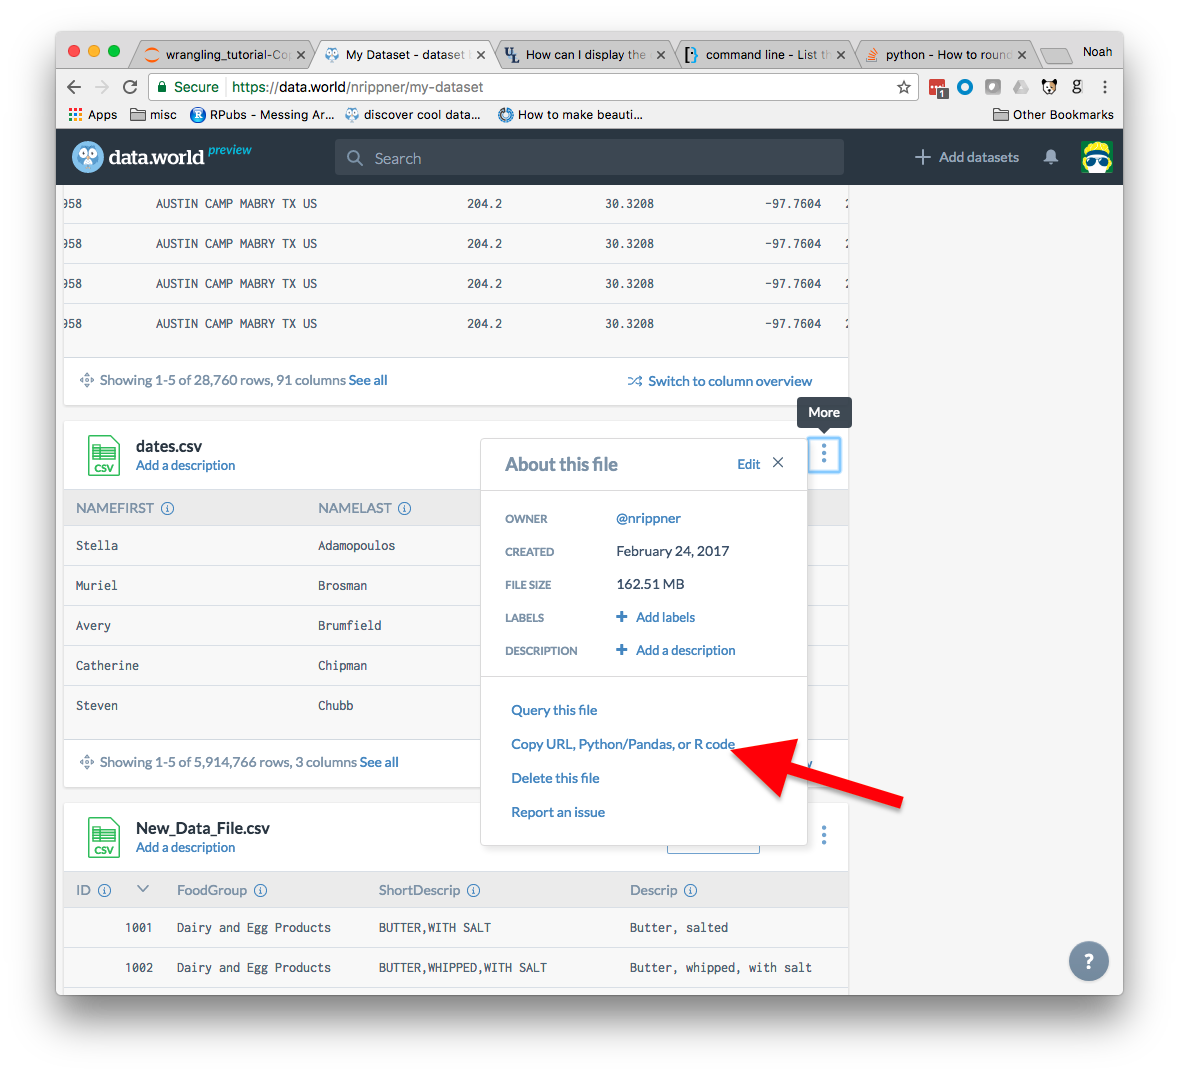

In [3]:
# paste results:
dates_dataframe = pd.read_csv('https://query.data.world/s/hmbt8lm4cw6yj9vshigs178m')

In [4]:
print(dates_dataframe.shape)
dates_dataframe.head(3)

(5914767, 3)


,NAMEFIRST,NAMELAST,APPT_START_DATE
0,Stella,Adamopoulos,5/1/15
1,Muriel,Brosman,5/1/15
2,Avery,Brumfield,5/1/15


Our objective now is to convert the `APPT_START_DATE column` to a Series of Pandas datetime objects. The column's dtype is currently numpy `object_` and the individual values are strings.

In [5]:
print(dates_dataframe.APPT_START_DATE.dtype)
print(dates_dataframe.APPT_START_DATE[0], type(dates_dataframe.APPT_START_DATE[0]))

object
5/1/15 <class 'str'>


This seems like it should be relatively simple -- we could just pass the `df.APPT_START_DATE` to the `pandas.to_datetime()` function. Let's try it on a slice made up of the first five percent of the data.

In [6]:
start = time.time()
test = pd.to_datetime(dates_dataframe.APPT_START_DATE[:295738])
end = time.time()
print("%.2f" % (end-start))

53.11


In [7]:
(52.3 * 20) / 60.0

17.433333333333334

Processing 1/20 of the data on my machine took 52 seconds. At that rate, all the rows will take more than 17 minutes. Let's see if we can speed it up.     

In [8]:
start = time.time()
def lookup(series):
    dates = {date:pd.to_datetime(date, errors='coerce') for date in series.unique()} 
    return series.map(dates)
dates_dataframe['NewDate'] = lookup(dates_dataframe.APPT_START_DATE)
end = time.time()
print("%.2f" % (end-start))
print("Couldn't be parsed:", sum(dates_dataframe.NewDate.isnull()) - sum(dates_dataframe.APPT_START_DATE.isnull()) )   

44.12
Couldn't be parsed: 165


In [9]:
print("Number of rows:", dates_dataframe.shape[0])
print("Number of unique dates:", len(dates_dataframe.APPT_START_DATE.unique()))

Number of rows: 5914767
Number of unique dates: 158151


In this example :
* we define a function called `lookup` which is intended to take as its argument a Pandas Series
* using `dictionary comprehension`, we iterate over each item in the set of unique values in our original series and map each to a `Pandas datetime` object created using the `to_datetime` function
* the `errors='coerce'` parameter tells the `to_datetime` function to return `np.nan` for values for which a datetime format cannot be inferred
* using the `pandas.Series.map` method, we return a new Series based on the key:value mappings in our dictionary comprehension.
* using this approach, we finished in 42 seconds -- a 96% reduction in processing time!     

Before moving on, let's think about what caused Pandas `to_datetime` to take so long (17 minutes). Pandas `to_datetime` can be drastically sped up by including an additional argument: "_`format=`_".     
 > new_series = pd.to_datetime(old_series, format="%Y/%m/%d")     
 
By specifying the format, the `to_datetime` algorithm skips the step of trying to infer the format, resulting in much shorter processing time. However, as we'll see, we could not use the format argument with this data.    
Let's take a closer look at the datetime column.

In [10]:
# helpful technique to look at composition of a column
dates_dataframe['APPT_START_DATE'] = dates_dataframe.APPT_START_DATE.apply(lambda x: str(x))
lengths = pd.Series([len(j) for _, j in enumerate(dates_dataframe.APPT_START_DATE.values)]).value_counts()
lengths

13    2058611
12    1351583
14    1339330
15     754861
11     258637
16     112105
8       13309
7        9488
10       8393
9        4049
6        1848
19       1639
20        581
18        325
1           3
17          2
3           2
5           1
dtype: int64

In [11]:
def inspect_date(length):
    return dates_dataframe[dates_dataframe.APPT_START_DATE.str.len() == length].APPT_START_DATE.values[0]
for i, j in zip(lengths.index, lengths.values):
    result = inspect_date(i)
    print("{:<20} {:>10} {:<2} {:>10} {:>7}".format(result, "length:", len(result), "count:", j))

2/24/10 10:30           length: 13     count: 2058611
3/5/10 10:15            length: 12     count: 1351583
12/13/09 16:00          length: 14     count: 1339330
8/22/2010 12:30         length: 15     count:  754861
5/1/15 7:00             length: 11     count:  258637
12/12/2011 18:30        length: 16     count:  112105
10/22/10                length: 8      count:   13309
9/23/10                 length: 7      count:    9488
12/12/2011              length: 10     count:    8393
1/27/2011               length: 9      count:    4049
5/1/15                  length: 6      count:    1848
5/19/2009 7:00:00AM     length: 19     count:    1639
2/24/2009 11:30:00AM    length: 20     count:     581
9/24/20096:00:00PM      length: 18     count:     325
                        length: 1      count:       3
3/6/20099:30:00AM       length: 17     count:       2
nan                     length: 3      count:       2
41948                   length: 5      count:       1


**The take-away here** is that the datetime column lacks a consistent format. Some entries contain hour:minute:seconds and some don't. Sometimes the year is represented with 4 digits, sometimes only 2.    
When we specify a format using "format=" in the function call, `to_datetime` throws an exception when encountering an unexpected type of datetime format. Our best bet, it appears, was the technique we used above, in which we used `to_datetime` on the set of unique values, rather than the full data.

# 2. Changing time zones     
This is pretty straightforward, but worth looking at.    

First, let's download and import some timestamp data that has hour:minute:second.

In [12]:
time_df = ddw.query('nrippner/datetime-sample',
                    'SELECT * FROM time_data LIMIT 1000').dataframe

time_df['created_date'] = pd.to_datetime(time_df.created_date)

* The `created_date` column (after feeding it to the `to_datetime` function) is a datetime64 object.  
* The individual objects that the `created_date` column comprises is a pandas Timestamp.

In [13]:
time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
id              1000 non-null int64
created_date    1000 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 15.7 KB


In [14]:
item = time_df.created_date[0]
print(item)
print(type(item))

2016-06-04 00:23:34
<class 'pandas._libs.tslib.Timestamp'>


Let's imagine that we want to convert the data to Central time. By default, pandas Timestamp objects are _time zone agnostic_. Therefore, we have to ascertain the baseline timezone, because the data alone will not tell us. In this case, let's assume that I either contacted the database administrator or the database's documentation and learned that the time stamps were measured in UTC format (a common standard for databases).   
     
Knowing we're starting from UTC, here's how to go about changing the time zone in pandas. We'll use the `pytz` to get a list of time zones.

In [15]:
all_tz = pytz.all_timezones
#all_tz

In [16]:
time_df['central_tz'] = time_df.created_date.apply(lambda x: x.tz_localize('UTC').tz_convert('US/Central'))

In [17]:
time_df.head()

,id,created_date,central_tz
0,555,2016-06-04 00:23:34,2016-06-03 19:23:34-05:00
1,556,2016-06-04 04:28:40,2016-06-03 23:28:40-05:00
2,565,2016-06-04 20:39:05,2016-06-04 15:39:05-05:00
3,655,2016-06-05 22:43:03,2016-06-05 17:43:03-05:00
4,1555,2016-06-17 01:07:05,2016-06-16 20:07:05-05:00


# 3. "Standardizing" text (string) columns      
In this section, we'll see how to correct discrepancies between two columns.     

> The typical use case is when you want to join two separate datasets, each with a common column to join on (for example, city name). More often than not we find spelling, syntax, or formatting differences between columns, which need to be brought into symmetry prior to executing a join.    

In this example, our goal is to join two datasets on a "Country" column. In this case, we're going to join a dataset on refugees by country with one for population by country, with the goal of creating a "Refugees Per Capita" feature.

In [18]:
refugee_df = ddw.query('nrippner/refugee-host-nations',
                       'SELECT Year, `unhcr_2015.csv/unhcr_2015`.`Country / territory of asylum/residence`'\
                       'FROM `unhcr_2015.csv/unhcr_2015`').dataframe

In [19]:
population_df = ddw.query('nrippner/refugee-host-nations',
                        '''SELECT `worldbank_indicators.csv/worldbank_indicators`.`2015 [YR2015]`,
                           `worldbank_indicators.csv/worldbank_indicators`.`Country Name`
                            FROM `worldbank_indicators.csv/worldbank_indicators`
                            WHERE `worldbank_indicators.csv/worldbank_indicators`.`Series Name`
                            LIKE "Population, total"''').dataframe

Rename columns to prepare for join

In [20]:
refugee_df.columns = ['Year', 'Country']
population_df.columns = ['Refugees', 'Country']

In [21]:
print("The refugee dataframe has %d unique Countries" % len(refugee_df.Country.unique()))
print("The population dataframe has %d unique Countries" % len(population_df.Country.unique()))

The refugee dataframe has 170 unique Countries
The population dataframe has 244 unique Countries


In [22]:
A = sum(pd.Series(refugee_df.Country.unique()).isin(population_df.Country))
B = sum(pd.Series(population_df.Country.unique()).isin(refugee_df.Country))
print("%d out of %d unique countries in refugee_df are in population_df" % (A, len(refugee_df.Country.unique())))
print("%d out of %d unique countries in population_df are in refugee_df" % (B, len(population_df.Country.unique())))

143 out of 170 unique countries in refugee_df are in population_df
143 out of 244 unique countries in population_df are in refugee_df


Take a look at the 27 countries in refugee_df that don't match

In [23]:
countries_unique = pd.Series(refugee_df.Country.unique())
countries_unique[~countries_unique.isin(population_df.Country)]
# (the ~ symbol before "countries" means "not")

7                                     Czech Rep.
11                                Dominican Rep.
14                                         Egypt
22              Micronesia (Federated States of)
28                                        Gambia
34                          China, Hong Kong SAR
42                        Iran (Islamic Rep. of)
53                                    Kyrgyzstan
55                                 Rep. of Korea
69                               Rep. of Moldova
73     The former Yugoslav Republic of Macedonia
92                                         Nauru
101                  Dem. People's Rep. of Korea
115        Serbia and Kosovo (S/RES/1244 (1999))
117                                     Slovakia
122                             Syrian Arab Rep.
132                      United Rep. of Tanzania
138                     United States of America
142           Venezuela (Bolivarian Republic of)
143                                     Viet Nam
144                 

Now let's correct the country names so the two dataframes match.  

In [24]:
# use list comprehension, the Python "enumerate" function, 
# and the pandas Series.isin() method to make list of non-matching countries
no_match = [[i, refugee_df.Country.unique()[i]] for i, j in 
             enumerate(pd.Series(refugee_df.Country.unique()).isin(population_df.Country)) if not j]

In [25]:
no_match

[[7, 'Czech Rep.'],
 [11, 'Dominican Rep.'],
 [14, 'Egypt'],
 [22, 'Micronesia (Federated States of)'],
 [28, 'Gambia'],
 [34, 'China, Hong Kong SAR'],
 [42, 'Iran (Islamic Rep. of)'],
 [53, 'Kyrgyzstan'],
 [55, 'Rep. of Korea'],
 [69, 'Rep. of Moldova'],
 [73, 'The former Yugoslav Republic of Macedonia'],
 [92, 'Nauru'],
 [101, "Dem. People's Rep. of Korea"],
 [115, 'Serbia and Kosovo (S/RES/1244 (1999))'],
 [117, 'Slovakia'],
 [122, 'Syrian Arab Rep.'],
 [132, 'United Rep. of Tanzania'],
 [138, 'United States of America'],
 [142, 'Venezuela (Bolivarian Republic of)'],
 [143, 'Viet Nam'],
 [144, 'Yemen'],
 [149, 'Bahamas'],
 [153, 'Bolivia (Plurinational State of)'],
 [157, 'Central African Rep.'],
 [163, "Côte d'Ivoire"],
 [166, 'Dem. Rep. of the Congo'],
 [167, 'Congo']]

In [26]:
# create dataframe
no_match = pd.DataFrame(no_match, index=range(len(no_match)), columns=['idx', 'Country'])

In [27]:
# fuzzy matching, list comprehension, and enumerate to help find matches
# from fuzzywuzzy import process
no_match['Matches'] = [process.extractBests(j, population_df.Country.unique(), limit=3,
                        score_cutoff=70) for _, j in enumerate(no_match.Country.values)]

In [28]:
pd.options.display.max_colwidth = 80
no_match

,idx,Country,Matches
0,7,Czech Rep.,"[(Czech Republic, 90), (Congo, Dem. Rep., 86), (Egypt, Arab Rep., 86)]"
1,11,Dominican Rep.,"[(Dominica, 90), (Korea, Dem. People’s Rep., 86), (Dominican Republic, 84)]"
2,14,Egypt,"[(Egypt, Arab Rep., 90)]"
3,22,Micronesia (Federated States of),"[(Isle of Man, 86), (Micronesia, Fed. Sts., 86), (United States, 86)]"
4,28,Gambia,"[(Gambia, The, 90), (Zambia, 83), (Namibia, 77)]"
5,34,"China, Hong Kong SAR","[(Hong Kong SAR, China, 95), (China, 90), (Macao SAR, China, 71)]"
6,42,Iran (Islamic Rep. of),"[(Iran, Islamic Rep., 95), (Congo, Rep., 86), (Isle of Man, 86)]"
7,53,Kyrgyzstan,[]
8,55,Rep. of Korea,"[(Korea, Rep., 95), (Korea, Dem. People’s Rep., 86)]"
9,69,Rep. of Moldova,"[(Moldova, 90), (Congo, Rep., 86), (Korea, Dem. People’s Rep., 86)]"


In [29]:
population_df[population_df.Country.str.contains('Venez')]

,Refugees,Country
207,31108083.0,"Venezuela, RB"


In [30]:
repl = { 'Country' : {'Czech Rep.':'Czech Republic',
                      'Dominican Rep.':'Dominican Republic',
                      'Egypt':'Egypt, Arab Rep.',
                      'Micronesia (Federated States of)':'Micronesia, Fed. Sts.',
                      'Gambia':'Gambia, The',
                      'China, Hong Kong SAR':'Hong Kong SAR, China',
                      'Iran (Islamic Rep. of)':'Iran, Islamic Rep.',
                      'Kyrgyzstan':'Kyrgyz Republic',
                      'Rep. of Korea':'Korea, Rep.',
                      'Serbia and Kosovo (S/RES/1244 (1999))':'Serbia',
                      'Slovakia':'Slovak Republic',
                      'Syrian Arab Rep.':'Syrian Arab Republic',
                      'United Rep. of Tanzania':'Tanzania',
                      'United States of America':'United States',
                      'Venezuela (Bolivarian Republic of)':'Venezuela, RB',
                      'Viet Nam':'Vietnam',
                      'Yemen':'Yemen, Rep.',
                      'Bahamas':'Bahamas, The',
                      'Bolivia (Plurinational State of)':'Bolivia',
                      'Central African Rep.':'Central African Republic',
                      'Côte d\'Ivoire':'Cote d\'Ivoire',
                      'Dem. Rep. of the Congo':'Congo, Dem. Rep.',
                      'Congo':'Congo, Rep.',
                      'Rep. of Moldova':'Moldova',
                      'The former Yugoslav Republic of Macedonia':'Macedonia, FYR',
                      'Dem. People\'s Rep. of Korea':'Korea, Dem. People’s Rep.'
                     }
       }

refugee_df.replace(repl, inplace=True)

In [31]:
ref_unique = pd.Series(refugee_df.Country.unique())
ref_unique[~ref_unique.isin(population_df.Country)]

92    Nauru
dtype: object

# 4. Multiprocessing      
Hat tip to [this blog](http://www.racketracer.com/2016/07/06/pandas-in-parallel/), where I discovered this technique.      
Sometimes despite our best efforts to write good Python/Pandas code, we have complex computations that we'd like to speed up. For processor-intensive jobs, multiprocessing is a solution.    

In [38]:
#import multiprocessor as mp

# first, define the function that you want to distribute across multiple CPU cores
# Note, this is a poorly written function, so we can play with multiprocessing
def func(s_split):
    
    def apply_func(x):
        count = 0
        for letter in list(x):
            for country in population_df.Country.values:
                if letter in list(country):
                    count += 1
        return count
    
    for n in range(20):
        out = s_split.apply(apply_func)
    return out

# multiprocessing
num_partitions = 12
num_cores = 8

def parallelize_series(s, func):
    s_split = np.array_split(s, num_partitions)
    pool = mp.Pool(num_cores)
    output = pd.concat(pool.map(func, s_split))
    pool.close()
    pool.join()
    return output

start = time.time()
func(refugee_df.Country)
end = time.time()
print("single job: %.2f" % (end - start))

start = time.time()
ref_unique['letter_counts'] = parallelize_series(refugee_df.Country, func)
end = time.time() 
print("multiprocessor: %.2f" % (end - start))

single job: 108.71
multiprocessor: 28.97


We see the improvement in processing time.   
The screenshot shows the jobs running concurrently on different cores of my quad-core laptop.

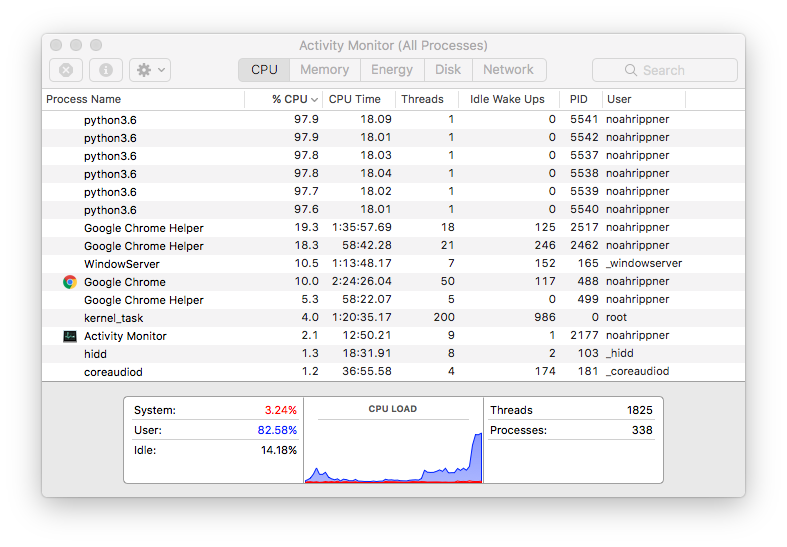

# 5. Reshaping dataframes with melt & pivot    

**transform from "wide" to "long" format using melt**    
For this exercise, we'll use the [Worldbank WDI Indicators data](https://data.world/worldbank/world-development-indicators) 

In [39]:
# population estimates by nation, by year
pop_dataframe = ddw.query('worldbank/world-development-indicators',
          '''SELECT * FROM `WDI_csv.zip/WDI_csv/WDI_Data.csv/WDI_Data`
             WHERE `WDI_csv.zip/WDI_csv/WDI_Data.csv/WDI_Data`.`Indicator Code` = "GC.TAX.TOTL.GD.ZS"''').dataframe


In [40]:
print(pop_dataframe.shape)
pop_dataframe.head()

(264, 61)


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Bermuda,BMU,Tax revenue (% of GDP),GC.TAX.TOTL.GD.ZS,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,East Asia & Pacific (IDA & IBRD countries),TEA,Tax revenue (% of GDP),GC.TAX.TOTL.GD.ZS,None,None,None,None,None,None,...,10.5211232605849,11.0512571856422,10.8993770066324,10.8236623308498,11.0734365585208,None,10.7913613491258,10.3669821984149,None,None
2,Bhutan,BTN,Tax revenue (% of GDP),GC.TAX.TOTL.GD.ZS,None,None,None,None,None,None,...,7.51946726950630,8.41593233961713,9.23552702504043,13.1432965226147,13.5075777539729,14.7041481596257,14.3778834457536,13.3368926386372,None,None
3,Bolivia,BOL,Tax revenue (% of GDP),GC.TAX.TOTL.GD.ZS,None,None,None,None,None,None,...,16.9648957779373,None,None,None,None,None,None,None,None,None
4,Bosnia and Herzegovina,BIH,Tax revenue (% of GDP),GC.TAX.TOTL.GD.ZS,None,None,None,None,None,None,...,21.3974496867264,20.3141077335623,18.9605013977038,19.7000140636424,20.3224260222236,20.5007238483636,19.7778885682037,19.8172706811392,19.9688147877335,None


In [41]:
pop_dataframe = pd.melt(pop_dataframe, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
               value_vars=pop_dataframe.columns[4:].values, var_name='Year', value_name='Tax_Rev_Percent_GDP')

In [42]:
print(pop_dataframe.shape)
pop_dataframe.head()

(15048, 6)


,Country Name,Country Code,Indicator Name,Indicator Code,Year,Tax_Rev_Percent_GDP
0,Bermuda,BMU,Tax revenue (% of GDP),GC.TAX.TOTL.GD.ZS,1960,None
1,East Asia & Pacific (IDA & IBRD countries),TEA,Tax revenue (% of GDP),GC.TAX.TOTL.GD.ZS,1960,None
2,Bhutan,BTN,Tax revenue (% of GDP),GC.TAX.TOTL.GD.ZS,1960,None
3,Bolivia,BOL,Tax revenue (% of GDP),GC.TAX.TOTL.GD.ZS,1960,None
4,Bosnia and Herzegovina,BIH,Tax revenue (% of GDP),GC.TAX.TOTL.GD.ZS,1960,None


**transform from "long" to "wide" using pivot_table**

In [51]:
# convert to numeric (errors='coerce' to convert strings to np.nan)
pop_dataframe['Tax_Rev_Percent_GDP'] = pd.to_numeric(pop_dataframe.Tax_Rev_Percent_GDP, errors='coerce')
# pivot from long to wide
pop_dataframe = pd.pivot_table(pop_dataframe, values='Tax_Rev_Percent_GDP', columns=['Year'],
                      index=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
                      aggfunc=np.mean)
# reset index
pop_dataframe.reset_index(inplace=True)

In [53]:
print(pop_dataframe.shape)
pop_dataframe.head()

(264, 48)


Year,Country Name,Country Code,Indicator Name,Indicator Code,1972,1973,1974,1975,1976,1977,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Afghanistan,AFG,Tax revenue (% of GDP),GC.TAX.TOTL.GD.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,6.883364,5.229756,6.039428,8.434998,9.123651,8.854568,7.471639,7.158330,NaN,NaN
1,Albania,ALB,Tax revenue (% of GDP),GC.TAX.TOTL.GD.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.839672,18.313552,NaN
2,Algeria,DZA,Tax revenue (% of GDP),GC.TAX.TOTL.GD.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,40.750393,37.431012,45.252935,35.142903,34.402769,37.185853,NaN,NaN,NaN,NaN
3,American Samoa,ASM,Tax revenue (% of GDP),GC.TAX.TOTL.GD.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Andorra,ADO,Tax revenue (% of GDP),GC.TAX.TOTL.GD.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
